In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
pd.options.mode.chained_assignment = None

import random
random.seed(68)

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

from rdkit import Chem


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from standardization_process import *
from data_split import train_test_split

In [3]:
def remove_bad_datapoints(df,controlled_list,value_col,fold=np.log10(3)):
    bad_datapoints_index = unreliable_datapoints(df, controlled_list, value_col)
    df = df.loc[~df.index.isin(bad_datapoints_index),] 
    
    bad_group_index = identify_unreliable_group(df, controlled_list, value_col, fold=fold)
    
    df = df.loc[~df.index.isin(bad_group_index),] 
    
    return df

In [4]:
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
def compound_property_analysis(mol_list):
    atom_counts = mol_list.map(lambda x: x.GetNumAtoms())
    atom_counts = [x for x in atom_counts if x <=100]
    qed = mol_list.parallel_apply(Descriptors.qed)
    logp = mol_list.parallel_apply(Descriptors.MolLogP)
    TPSA = mol_list.parallel_apply(Descriptors.TPSA)
    HBD = mol_list.parallel_apply(Descriptors.NumHDonors)
    HBA = mol_list.parallel_apply(Descriptors.NumHAcceptors)
    
    fig, axs = plt.subplots(3,2, figsize=(16, 10))

    # Plot data
    axs[0, 0].hist(qed, bins=20, color='b', alpha=0.7, label='A')
    axs[0, 0].set_title('qed')
    
    axs[0, 1].hist(atom_counts, bins=40 , color='r', alpha=0.7, label='B')
    axs[0, 1].set_title('atom_counts')

    axs[1, 0].hist(logp, bins=20, color='g', alpha=0.7, label='C')
    axs[1, 0].set_title('logp')

    axs[1, 1].hist(TPSA, bins=20, color='y', alpha=0.7, label='D')
    axs[1, 1].set_title('TPSA')

    axs[2, 0].hist(HBD, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 0].set_title('HBD')

    axs[2, 1].hist(HBA, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 1].set_title('HBA')

    # Add some labels and titles for better readability
    for ax in axs.flat:
        ax.set( ylabel='Frequency')


    plt.show()

# Load data

In [5]:
all_data = pd.read_csv('../data/data_processing_result/logd_preprocessing_finished.csv')

In [6]:
all_data.head()

,Smiles_unify,Smiles,value,source,ph,property
0,C[C@@H]1CN([C@H](c2ccc(CCC(=O)O)cc2)c2cccc(O)c...,C[C@@H]1CN([C@H](c2ccc(CCC(=O)O)cc2)c2cccc(O)c...,2.1,CHEMBL861858,7.4,logd
1,O=C(O)COc1ccc(C(F)(F)F)cc1-c1ccc(Cl)cc1,O=C(O)COc1ccc(C(F)(F)F)cc1-c1ccc(Cl)cc1,0.9,CHEMBL1780748,7.4,logd
2,CS(=O)(=O)c1ccc(-c2cc(C(F)(F)F)ccc2OCC(=O)O)c(...,CS(=O)(=O)c1ccc(-c2cc(C(F)(F)F)ccc2OCC(=O)O)c(...,0.5,CHEMBL1780748,7.4,logd
3,CCS(=O)(=O)c1ccc(-c2cc(C(F)(F)F)ccc2OCC(=O)O)c...,CCS(=O)(=O)c1ccc(-c2cc(C(F)(F)F)ccc2OCC(=O)O)c...,0.5,CHEMBL1780748,7.4,logd
4,CCS(=O)(=O)c1ccc(-c2cc(C(F)(F)F)ccc2O[C@@H](C)...,CCS(=O)(=O)c1ccc(-c2cc(C(F)(F)F)ccc2O[C@@H](C)...,0.4,CHEMBL1780748,7.4,logd


<AxesSubplot:>

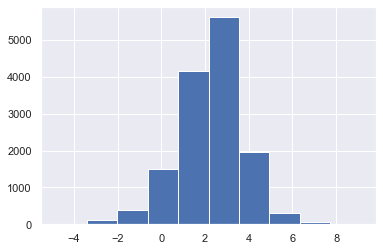

In [7]:
all_data['value'].hist()

# Further filtering

In [8]:
df_remove_bad_data = remove_bad_datapoints(all_data,['Smiles_unify','ph'],'value',fold=np.log10(3))

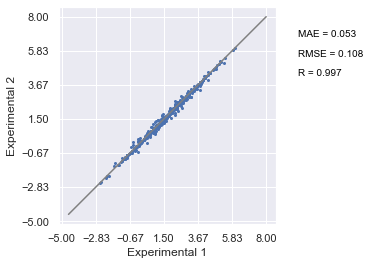

In [9]:
plot_diagram(df_remove_bad_data, ['Smiles_unify','ph'], 'value')

In [10]:
df = final_mean_value(df_remove_bad_data,['Smiles_unify','ph'], 'value')

In [11]:
df['value'] = df['value_mean'].copy()

In [12]:
df = df.drop_duplicates('Smiles_unify')

In [16]:
df = df[['Smiles_unify','value','property']]

# Compound Property analysis

In [17]:
mol_list = df['Smiles_unify'].map(Chem.MolFromSmiles)

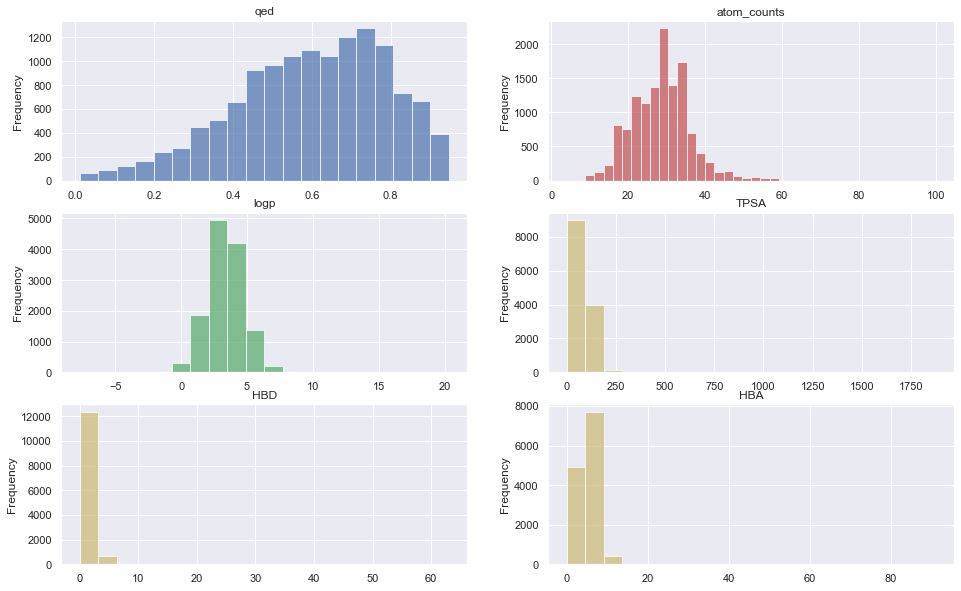

In [18]:
compound_property_analysis(mol_list)

# Data Split

In [19]:
df =  df.reset_index()

In [20]:

train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=True)
df.loc[train_index,'scaffold_train_test_label'] = 'train'
df.loc[test_index,'scaffold_train_test_label'] = 'test'

train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=False)
df.loc[train_index,'random_train_test_label'] = 'train'
df.loc[test_index,'random_train_test_label'] = 'test'

100%|██████████████████████████████████| 13068/13068 [00:01<00:00, 11077.94it/s]


In [21]:
df.to_csv('../data/final_datasets/logd_reg_final_data.csv',index=False)

In [22]:
df.shape

(13068, 6)